# K-Space operations

In this Notebook, we will explore some basic properties of K-Space.

## Initialization

The following code imports the required packages, the dataset that we will be using, and shows the image.

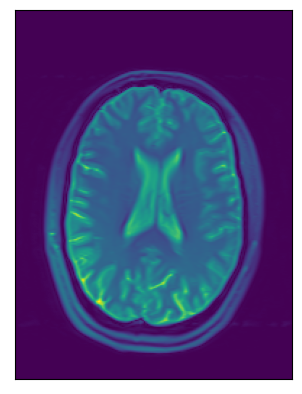

In [2]:
import numpy as np
from numpy.fft import *
from scipy.signal import sawtooth
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
ima = np.load('mrimage.npy')

def show_image(ima, *args, **kwargs):
    plt.imshow(ima, *args, **kwargs)
    plt.axis('image')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

from threading import Timer

def interactive_int(fn, limits, debounce_time = 0.1):
    out = widgets.Output()
    default = int((limits[1]-limits[0])/2)
    slider = widgets.IntSlider(min=limits[0],max=limits[1],step=limits[2], value=default)    
    
    def callback_fn(value):
        with out:
            out.clear_output(wait=True)
            fn(value.new)
        
    slider.observe(callback_fn, 'value')
    with out:
        fn(default)
    display(slider,out)
    
show_image(ima)

The image is a Fourier pair with its K-Space

$\text{Image} \overset{\mathcal{F}}{\leftrightarrow} \text{KSpace}$

We can show this here:

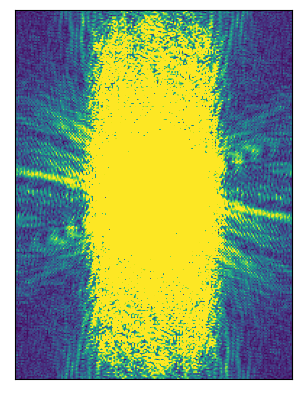

In [3]:
kspace = fftshift(fft2(ima)) # we are using fftshift to put the k-space center in the center of the image
show_image(abs(kspace), vmax = 5000)

Notice how the K-Space has the same dimensions as the image.

Now we can go back using the inverse Fourier transform:

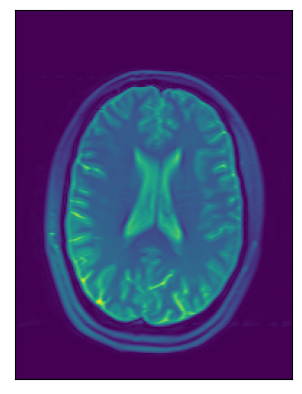

In [4]:
ima2 = abs(ifft2(kspace))
show_image(abs(ima2))

## Undersampling the k-space

Here we show how the image is affected if only the even (odd) lines of k-space are taken. This corresponds to undersampling in K-Space, that is, the step between one phase encoding line and the next has become more coarse.

In [5]:
underSampling = 2 # Change this value for different results!
kspace2 = np.copy(kspace)
kspace2 = kspace2[0::underSampling,:]

This is how the K-Space looks like (notice that, obviously, its size in the vertical direction has halved):

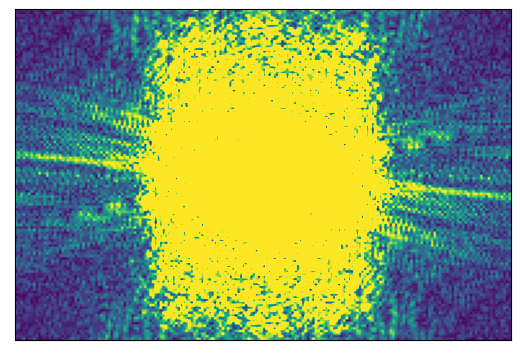

In [6]:
show_image(abs(kspace2), vmax=5000)

And moving back into the image space, we notice that the size of the image has also halved, the field of view is halved too, and aliasing appears:

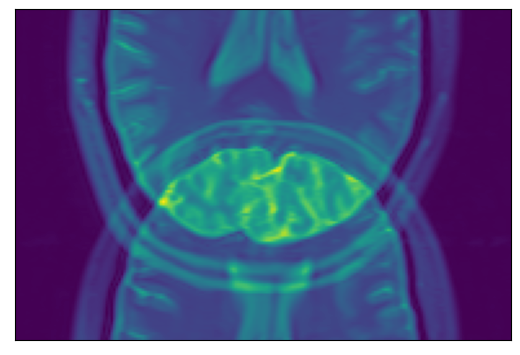

In [7]:
show_image(abs(ifft2(kspace2)))

### Zero-filling

Alternatively, we can set every other line of k-space to zero, instead of removing it. This is called zero-filling the K-Space:

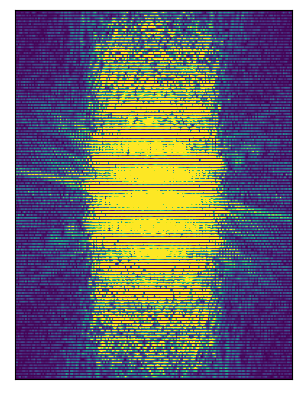

In [8]:
kspace2 = np.zeros(kspace.shape, dtype=complex)
kspace2[0::underSampling,:] = kspace[0::underSampling,:]
show_image(abs(kspace2), vmax=5000)

The size of K-Space is the same as the original one, however we multiplied the lines by a comb function:

<StemContainer object of 3 artists>

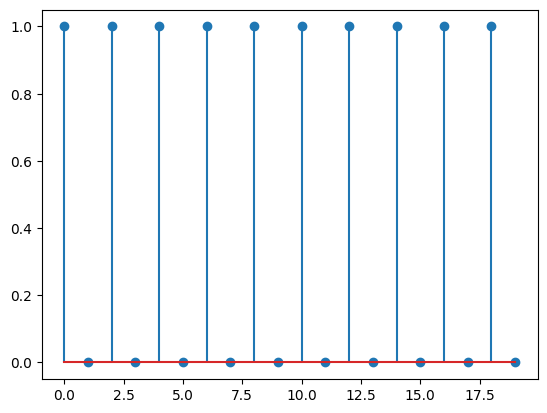

In [9]:
comb = np.zeros(underSampling*10)
comb[0::underSampling] = 1
plt.stem(comb)

Which, in image space, it is equivalent to a convolution by the Fourier transform of that same function. 

<StemContainer object of 3 artists>

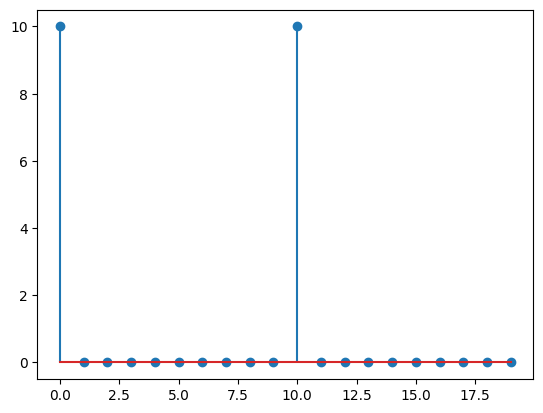

In [10]:
plt.stem(abs(fft(comb)))

As you can notice, the FT has two (or, in general, *underSampling*) peaks, which correspond to two replicas of the image in the image domain:

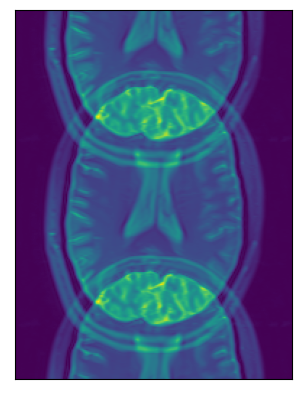

In [11]:
show_image(abs(ifft2(kspace2)))

In this case, the image size is the same as the original, but the field of view is still cropped. We just obtain more replicas of the same information, which is typical of undersampling.

## Cropping the K-Space
The other operation that we can do in K-Space is cropping, that is, we can leave out some portions of K-Space.

In this case, the field of view of the image is unchanged, because it is determined by the phase encoding steps and not the extent of the acquired K-Space.

### Removing the outer regions

The first operation that we will do will be removing the outer regions of k-space:

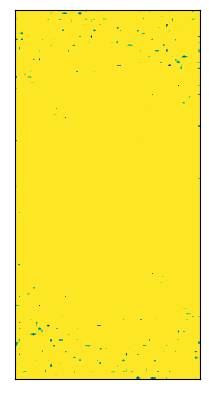

In [12]:
cutLines = 64 # change this value for different results!
kspace2 = np.copy(kspace)
kspace2 = kspace2[cutLines:-cutLines,cutLines:-cutLines]
show_image(abs(kspace2), vmax=5000)

The size of K-Space is reduced, and only the central 128 lines (out of 256) are kept. The image will be a scaled down version of the original:

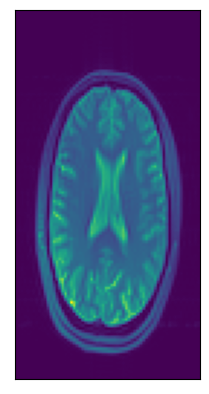

In [13]:
show_image(abs(ifft2(kspace2)))

### Zero-filling

The image size is now changed, so the image is effectively smaller. We can restore the original size by doing a zero-filling, like before:

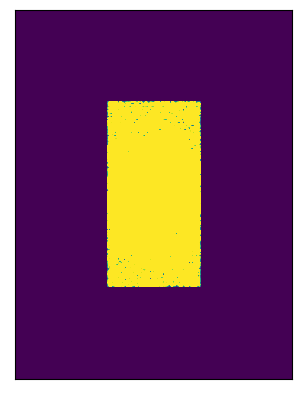

In [14]:
kspace2 = np.copy(kspace)
kspace2[0:cutLines,:] = 0
kspace2[-cutLines:,:] = 0
kspace2[:,0:cutLines] = 0
kspace2[:,-cutLines:] = 0
show_image(abs(kspace2), vmax=5000)

As we know, the outer regions of K-Space contain the information of the high spatial frequencies. The resulting image will be a reduced-resolution version of the original one:

Text(0.5, 1.0, 'Original image')

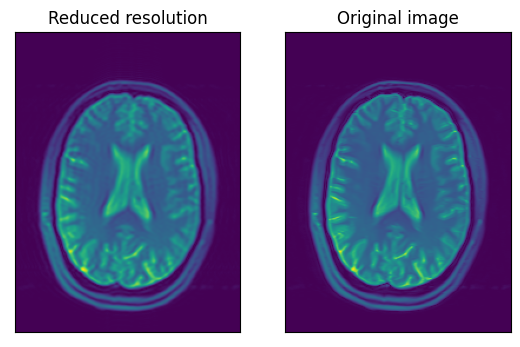

In [15]:
plt.subplot(121)
show_image(abs(ifft2(kspace2)))
plt.title("Reduced resolution")
plt.subplot(122)
show_image(abs(ifft2(kspace)))
plt.title("Original image")

Here's the difference of the two images:

Text(0.5, 1.0, 'Difference')

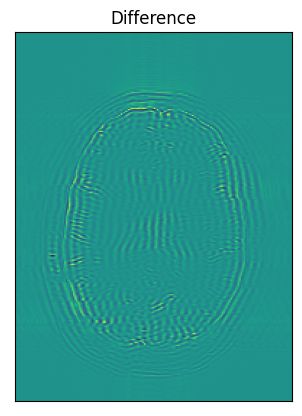

In [16]:
show_image(abs(ifft2(kspace2)) - abs(ifft2(kspace)))
plt.title("Difference")

## Removing the center of K-Space

The center of K-Space contains information about the lower spatial frequencies, i.e. the contrast of the image.

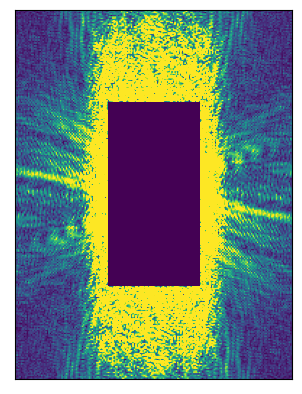

In [17]:
kspace2 = np.copy(kspace)
kspace2[cutLines:-cutLines,cutLines:-cutLines] = 0
show_image(abs(kspace2), vmax=5000)

The corresponding image will be the following:

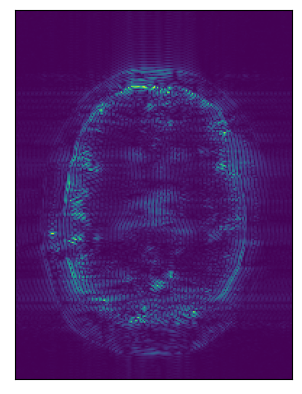

In [18]:
show_image(abs(ifft2(kspace2)))

This is the end of our tutorial on K-Space. If you would like to play with different options, you can first try changing the variable of the "cutLines" variable above, to remove smaller or larger portions of K-Space.

## Interactive examples

Here you can find some of the previous examples with a nice interactive interface:

### Undersampling

In [19]:
def interactiveImage(underSampling):
    kspace2 = np.zeros(kspace.shape, dtype=complex)
    kspace2[0::underSampling,:] = kspace[0::underSampling,:]
    plt.subplot(121)
    show_image(abs(kspace2), vmax=5000)
    plt.subplot(122)
    show_image(abs(ifft2(kspace2)))
    plt.axis('image')
    plt.show()
    
interactive_int(interactiveImage, (1,8,1), 0.3)

IntSlider(value=3, max=8, min=1)

Output()

### Zero-filling of outer k-space

In [20]:
def interactiveImage(cutLines):
    kspace2 = np.copy(kspace)
    kspace2[0:cutLines,:] = 0
    kspace2[-cutLines:,:] = 0
    kspace2[:,0:cutLines] = 0
    kspace2[:,-cutLines:] = 0
    plt.subplot(121)
    show_image(abs(kspace2), vmax=5000)
    plt.subplot(122)
    show_image(abs(ifft2(kspace2)))
    plt.axis('image')
    plt.show()
    
interactive_int(interactiveImage, (1,90,1))

IntSlider(value=44, max=90, min=1)

Output()

### Zero-filling of inner k-space

In [21]:
def interactiveImage(cutLines):
    kspace2 = np.copy(kspace)
    minSiz = np.min(kspace2.shape)
    cut = int(minSiz/2-cutLines)
    kspace2[cut:-cut,cut:-cut] = 0
    plt.subplot(121)
    show_image(abs(kspace2), vmax=5000)
    plt.subplot(122)
    show_image(abs(ifft2(kspace2)))
    plt.axis('image')
    plt.show()

interactive_int(interactiveImage, (1,90,1))

IntSlider(value=44, max=90, min=1)

Output()

# Artifacts

This section contains exercises about artifacts in image an k-space

## Motion artifacts

Motion artifacts introduce a modulation of k-space, because the actual image changes with every line we acquire.

Text(0.5, 1.0, 'Difference image')

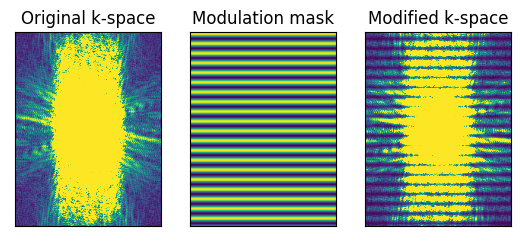

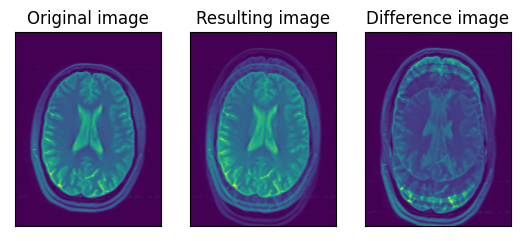

In [22]:
modulation = 0.8*np.sin(np.linspace(0,20,kspace.shape[0])*2*np.pi) + 1
modulation_mask = np.stack([modulation]*kspace.shape[1]).T
plt.subplot(1,3,1)
show_image(np.abs(kspace), vmax=5000)
plt.title('Original k-space')

plt.subplot(1,3,2)
show_image(modulation_mask)
plt.title('Modulation mask')

plt.subplot(1,3,3)
kspace2 = kspace * modulation_mask
show_image(np.abs(kspace2), vmax=5000)
plt.title('Modified k-space')

plt.figure()
plt.subplot(1,3,1)
show_image(abs(ifft2(kspace)))
plt.title('Original image')

plt.subplot(1,3,2)
show_image(abs(ifft2(kspace2)))
plt.title('Resulting image')

plt.subplot(1,3,3)
show_image(abs(ifft2(kspace2)) - abs(ifft2(kspace)))
plt.title('Difference image')

### Blood pulsation artifacts

A vessel that crosses the slice will be subject to different inflow effects depending on the cardiac phase. When the blood flow is higher, the vessel signal will be more intense, and vice versa. We will simulate this by having an area of the image change in intensity.

Text(0.5, 1.0, 'Difference image')

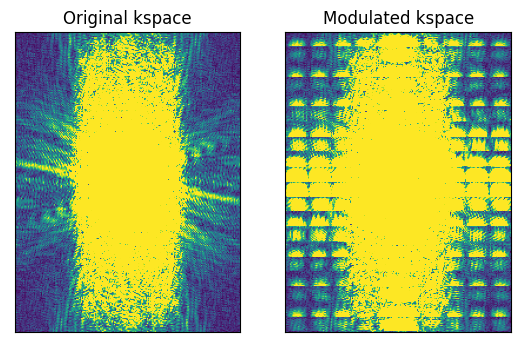

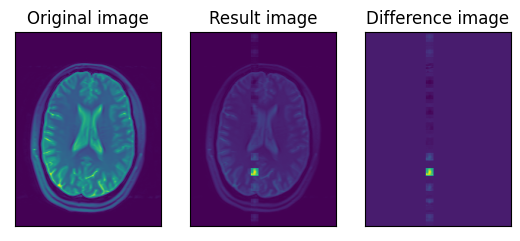

In [23]:
ima_stack = np.stack([ima]*kspace.shape[0], axis=-1)
vessel_mask = np.zeros_like(ima)
vessel_mask[180:190, 80:90] = 1
modulation = 5*sawtooth(np.linspace(0,20,kspace.shape[0])*2*np.pi)+5 # use the same modulation as before
modulated_vessel_list = []
for time in range(kspace.shape[0]):
    modulated_vessel_list.append(vessel_mask*modulation[time])
modulated_vessel_stack = np.stack(modulated_vessel_list, axis=-1)
modulated_ima_stack = ima_stack * (1+modulated_vessel_stack)

# perform the fft to go back to kspace
modulated_kspace = np.zeros_like(kspace)
for time in range(kspace.shape[0]):
    modulated_kspace[time, :] = fftshift(fft2(modulated_ima_stack[:,:,time]))[time, :]
    
plt.subplot(1,2,1)
show_image(abs(kspace), vmax = 5000)
plt.title('Original kspace')

plt.subplot(1,2,2)
show_image(abs(modulated_kspace), vmax = 5000)
plt.title('Modulated kspace')


plt.figure()
plt.subplot(1,3,1)
show_image(ima)
plt.title('Original image')

plt.subplot(1,3,2)
show_image(abs(ifft2(modulated_kspace)))
plt.title('Result image')

plt.subplot(1,3,3)
show_image(abs(ifft2(modulated_kspace)) - ima)
plt.title('Difference image')

## RF and hardware failures

RF interferences and hardware failures have typical appearances, also related to the acquisition in k-space.

### RF interference

An RF interference artifact, also called "zipper" artifact, is due to RF energy at a specific frequency picked up by a receive coil. As the phase of the RF energy varies for every k-space line, its appearance is somehow similar to a blood pulsatility artifact. If the phase was synchronized, it would appear as a single spot.

Text(0.5, 1.0, 'Corrupted image')

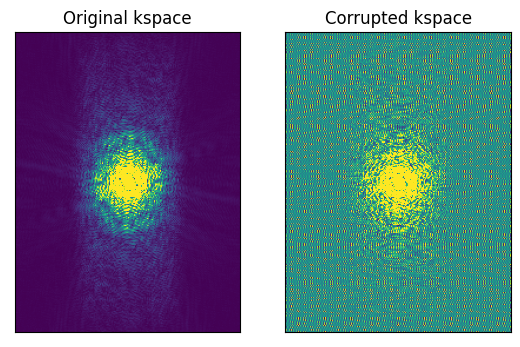

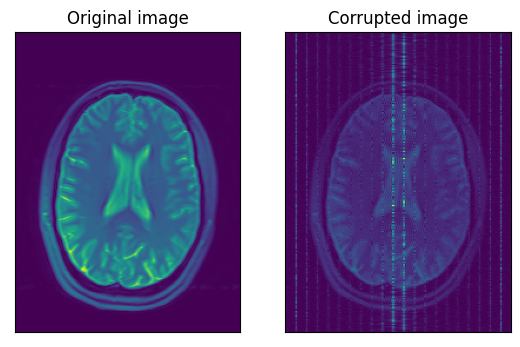

In [24]:
kspace2 = np.copy(kspace)
rfInterference = 1000*sawtooth(np.linspace(0,1000,kspace.shape[1])*2*np.pi)
for line in range(kspace.shape[0]):
    kspace2[line,:] += 100000*sawtooth(np.random.rand(1)*100 + np.linspace(0,100,kspace.shape[1])*2*np.pi)

plt.subplot(1,2,1)
show_image(abs(kspace), vmax = 100000)
plt.title('Original kspace')

plt.subplot(1,2,2)
show_image(abs(kspace2), vmax = 100000)
plt.title('Corrupted kspace')

plt.figure()
plt.subplot(1,2,1)
show_image(ima)
plt.title('Original image')

plt.subplot(1,2,2)
show_image(abs(ifft2(kspace2)))
plt.title('Corrupted image')

### Amplifier failure

A failure in an RF amplifier causes a spike in a single location in K-Space. This results in a sinusoidal modulation over the image.

Text(0.5, 1.0, 'Corrupted image')

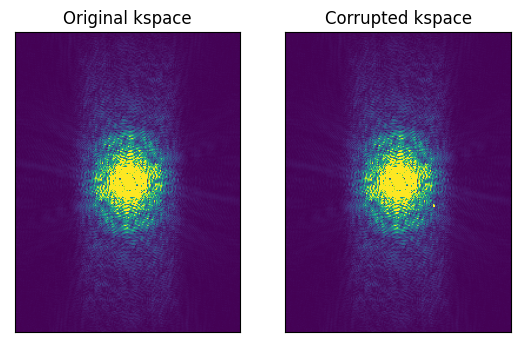

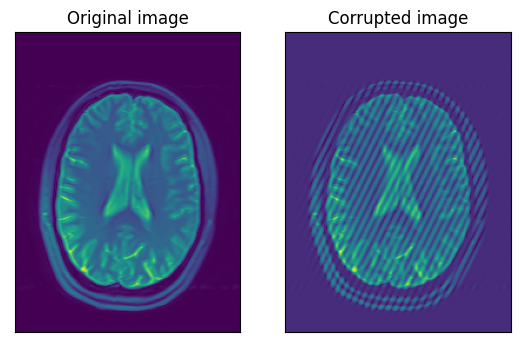

In [25]:
kspace2 = np.copy(kspace)
kspace2[(kspace.shape[0]//2) + 20,(kspace.shape[1]//2) + 30] = 10000000

plt.subplot(1,2,1)
show_image(abs(kspace), vmax = 100000)
plt.title('Original kspace')

plt.subplot(1,2,2)
show_image(abs(kspace2), vmax = 100000)
plt.title('Corrupted kspace')

plt.figure()
plt.subplot(1,2,1)
show_image(ima)
plt.title('Original image')

plt.subplot(1,2,2)
show_image(abs(ifft2(kspace2)))
plt.title('Corrupted image')